In [ ]:
## TLS Finder For querying TLS presence

'''If you use this code please cite as__ TLS_Finder: An algorithm for Identifying Tertiary Lymphoid Structures Using Immune Cell Spatial Coordinates
 ; Ayse A Koksoy, Maria Esther Salvatierra, MOSAIC Team, Luisa Maren Solis Soto, Cara Haymaker; 
doi: https://doi.org/10.1101/2024.12.26.630405'''

'''TLS maturation has been categorized into three stages: (i) early TLS, characterized by dense lymphocytic aggregates without follicular dendritic cells (fDCs); (ii) primary follicle-like TLS, having B cell clusters and an fDC network without Germination Center; and (iii) secondary follicle-like TLS, which includes B cell clusters, an fDC network, and Germonation Center with organized B cell cluster in the center surrounded by T cells'''

''' In this dataset CD8 marks T cells, CD20 marks B cells, CD68 marks Macrophages'''


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import networkx as nx

In [ ]:
dfs = pd.read_csv('/path/to/your/file_with_phenoytped_cells_and_coordinates.csv')

In [29]:
dfs

,Object Id,CD8,CD20,CD68,X,Y
0,0,CD8,0,0,9618.0,3715.5
1,1,CD8,0,0,9527.5,3720.0
2,2,0,CD20,CD68,9382.0,3718.5
3,3,CD8,0,0,9571.0,3719.0
4,4,CD8,0,CD68,9914.5,3740.5
...,...,...,...,...,...,...
243014,243014,0,0,0,15089.0,36883.0
243015,243015,0,0,0,15027.5,36897.5
243016,243016,0,0,0,14976.0,36909.0
243017,243017,0,0,0,14953.5,36912.5


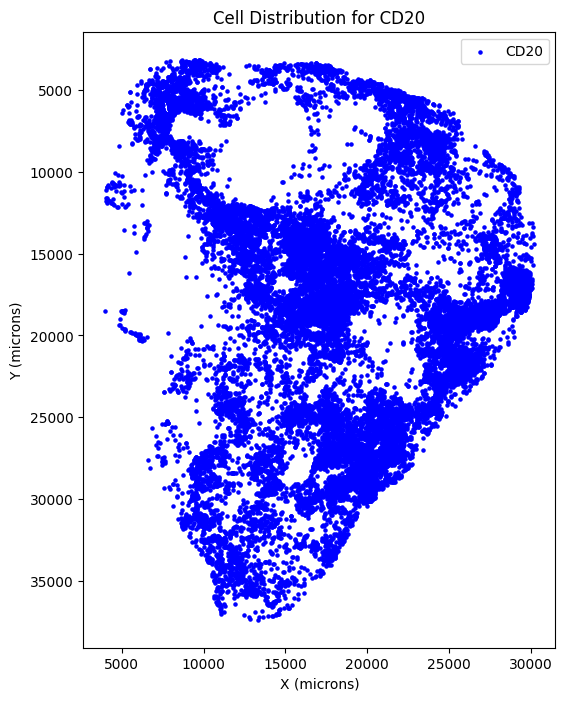

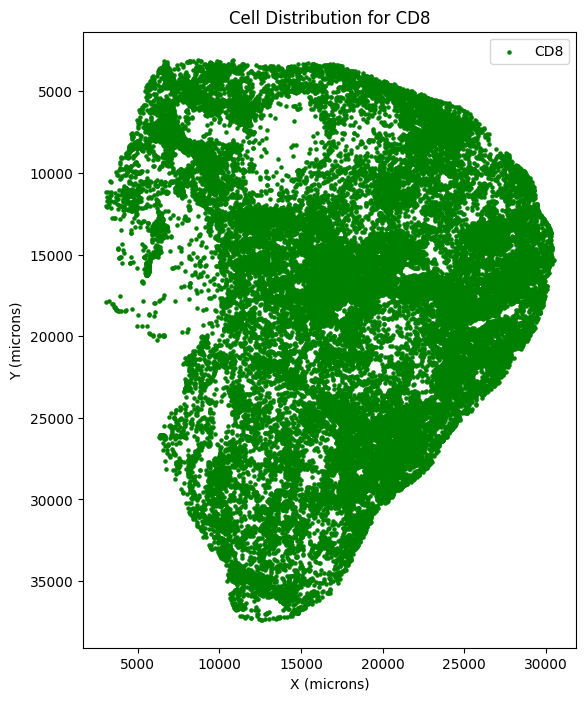

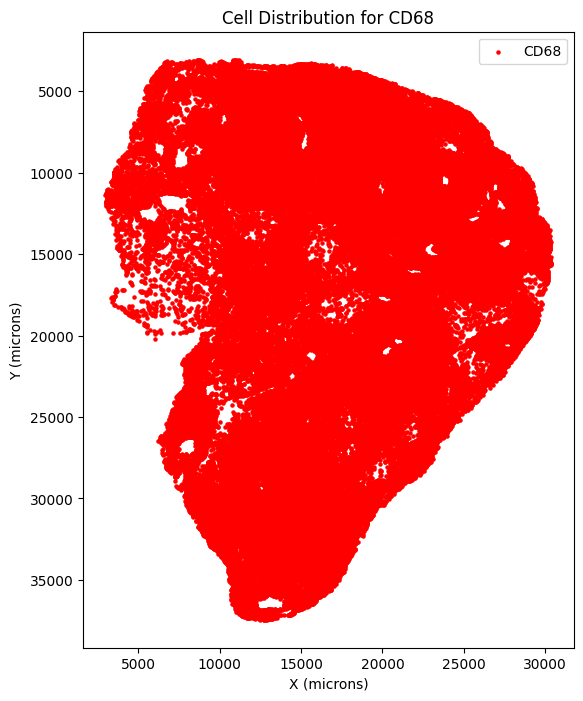

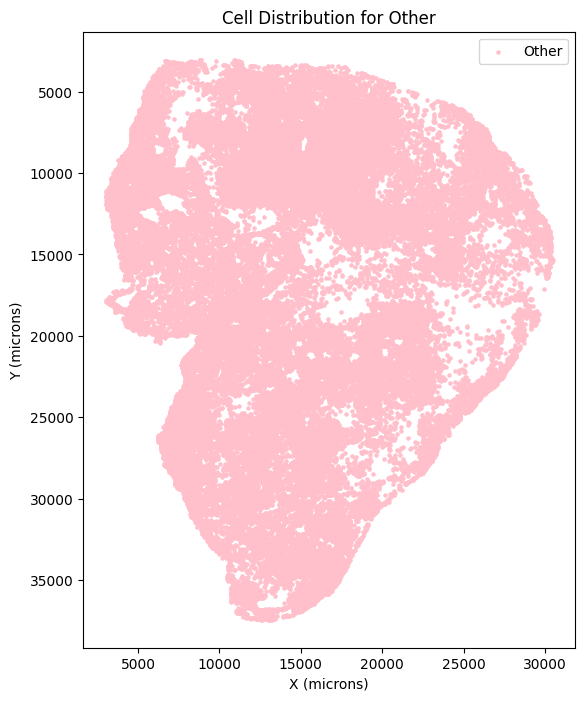

In [27]:

color_mapping = {
    'CD20': 'blue', 
    'CD8': 'green', 
    'CD68': 'red',
    'Other':'pink',
}
marker_size =2

#Plot each phenotype on a separate graph
for phenotype, color in color_mapping.items():
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size as needed

    phenotype_data = dfs[dfs['Phenotype'] == phenotype]
    ax.scatter(phenotype_data['X'], phenotype_data['Y'], s=marker_size, color=color, label=phenotype)

    ax.invert_yaxis()  # Correct the orientation
    ax.set_aspect('equal')  # Set the aspect ratio to equal

    ax.set_xlabel('X (microns)')
    ax.set_ylabel('Y (microns)')
    ax.set_title(f'Cell Distribution for {phenotype}')
    ax.legend()

In [2]:
dfs = pd.read_csv('/path/to/your/file_with_phenoytped_cells_and_coordinates.csv')

In [27]:
dfs

,Unnamed: 0,Object Id,CD8,CD20,CD68,X,Y,Phenotype
0,0,0,3,0,0,9618.0,3715.5,CD8
1,1,1,3,0,0,9527.5,3720.0,CD8
2,2,2,0,3,3,9382.0,3718.5,CD20
3,3,3,3,0,0,9571.0,3719.0,CD8
4,4,4,3,0,3,9914.5,3740.5,CD8
...,...,...,...,...,...,...,...,...
243014,243014,243014,0,0,0,15089.0,36883.0,Other
243015,243015,243015,0,0,0,15027.5,36897.5,Other
243016,243016,243016,0,0,0,14976.0,36909.0,Other
243017,243017,243017,0,0,0,14953.5,36912.5,Other


In [3]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import networkx as nx

def measure_TLS(df, radius):
    """
    Classify clusters of cells into TLS categories.
    
    :param df: DataFrame with columns ['X', 'Y', 'Phenotype']
    :param radius: Radius to consider for neighborhood
    :return: DataFrame with TLS classification and centers
    """
    # Create KDTree for spatial querying
    tree = KDTree(df[['X', 'Y']].values)

    # Network for cluster analysis
    G = nx.Graph()

    # Add nodes
    for idx, row in df.iterrows():
        G.add_node(idx, phenotype=row['Phenotype'], x=row['X'], y=row['Y'])

    # Add edges based on spatial proximity
    for idx in G.nodes:
        neighbors = tree.query_ball_point(df.loc[idx, ['X', 'Y']], r=radius)
        for neighbor in neighbors:
            if neighbor != idx:
                G.add_edge(idx, neighbor)
    
    used_cells = set()

    # Initialize lists to store classification results and aggregate centers
    tls_classifications = []
    aggregate_centers = []
    aggregate_coordinates = []

    # Iterate over B and T cells
    for idx, row in df.iterrows():
        if row['Phenotype'] in ['CD20', 'CD8'] and idx not in used_cells:
            # Find neighboring cells
            neighbors = tree.query_ball_point([row['X'], row['Y']], r=radius)
            neighbor_phenotypes = df.iloc[neighbors]['Phenotype']

            # Count B and T cells, excluding used cells
            bt_cell_count = sum(1 for i in neighbors if i not in used_cells and df.at[i, 'Phenotype'] in ['CD20', 'CD8'])

            # Classification logic
            if bt_cell_count >= 50:
                classification = 'Lymphoid Aggregate'
                tls_classifications.append(classification)
                aggregate_centers.append(idx)
                aggregate_coordinates.append((row['X'], row['Y']))  # Append the coordinates

                # Mark all cells in this aggregate as used
                used_cells.update(neighbors)

    # Create a DataFrame for the results
    results_df = pd.DataFrame({
        'Aggregate_Center_Index': aggregate_centers,
        'Aggregate_Center_Coordinates': aggregate_coordinates,
        'Classification': tls_classifications
    })

    return results_df


In [8]:
tls_result3 = measure_TLS(dfs, radius=160)
if tls_result3.empty:
    print("No TLS classifications were made.")
else:
    print(tls_result3)


    Aggregate_Center_Index Aggregate_Center_Coordinates      Classification
0                     6558             (8094.0, 5375.5)  Lymphoid Aggregate
1                     6614             (8457.5, 5501.5)  Lymphoid Aggregate
2                     6715             (8015.0, 5716.0)  Lymphoid Aggregate
3                     6737             (8411.0, 5764.0)  Lymphoid Aggregate
4                     6817             (8106.5, 5928.5)  Lymphoid Aggregate
..                     ...                          ...                 ...
79                  174993           (25516.0, 22502.5)  Lymphoid Aggregate
80                  188309           (17807.0, 24972.5)  Lymphoid Aggregate
81                  199627           (19781.0, 27629.0)  Lymphoid Aggregate
82                  206820           (19701.0, 28525.0)  Lymphoid Aggregate
83                  209388           (19486.5, 27924.5)  Lymphoid Aggregate

[84 rows x 3 columns]


In [9]:
Result_df3 = pd.DataFrame(tls_result3)

In [10]:
Result_df3

,Aggregate_Center_Index,Aggregate_Center_Coordinates,Classification
0,6558,"(8094.0, 5375.5)",Lymphoid Aggregate
1,6614,"(8457.5, 5501.5)",Lymphoid Aggregate
2,6715,"(8015.0, 5716.0)",Lymphoid Aggregate
3,6737,"(8411.0, 5764.0)",Lymphoid Aggregate
4,6817,"(8106.5, 5928.5)",Lymphoid Aggregate
...,...,...,...
79,174993,"(25516.0, 22502.5)",Lymphoid Aggregate
80,188309,"(17807.0, 24972.5)",Lymphoid Aggregate
81,199627,"(19781.0, 27629.0)",Lymphoid Aggregate
82,206820,"(19701.0, 28525.0)",Lymphoid Aggregate


In [ ]:
##Plot the LA on the image

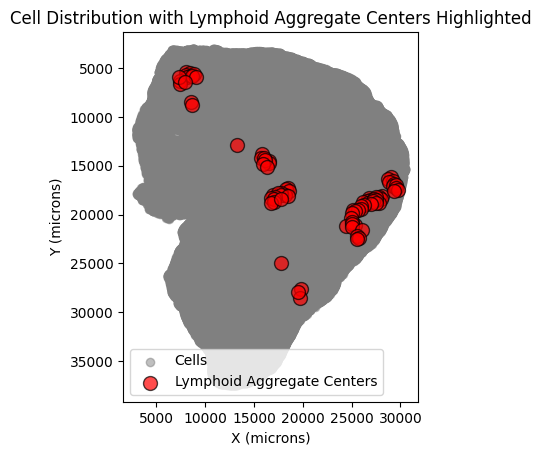

In [11]:
import matplotlib.pyplot as plt

# Assuming tls_results is the DataFrame returned by the measure_TLS function
# and it contains columns 'Aggregate_Center_Coordinates' and 'Classification'

# Create a figure and axis
fig, ax = plt.subplots()

# Plot all cells
ax.scatter(dfs['X'], dfs['Y'], color='gray', label='Cells', alpha=0.5)
ax.invert_yaxis()  # Correct the orientation
ax.set_aspect('equal')  # Set the aspect ratio to equal
# Highlight the lymphoid aggregate centers
# Check the format of 'Aggregate_Center_Coordinates' and adjust accordingly
# This assumes 'Aggregate_Center_Coordinates' is directly iterable (e.g., list of tuples)
aggregate_centers = tls_result3['Aggregate_Center_Coordinates'].tolist()
aggregate_x = [coord[0] for coord in aggregate_centers]
aggregate_y = [coord[1] for coord in aggregate_centers]

# Plot the aggregate centers
ax.scatter(aggregate_x, aggregate_y, color='red', label='Lymphoid Aggregate Centers', s=100, edgecolor='black', alpha=0.7)

# Add labels and legend
ax.set_xlabel('X (microns)')
ax.set_ylabel('Y (microns)')
ax.set_title('Cell Distribution with Lymphoid Aggregate Centers Highlighted')
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))

# Show the plot
plt.show()
